In [2]:
import os
import pandas as pd
from pathlib import Path
import kagglehub

from PIL import Image
from tqdm import tqdm
import imagehash

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
path_to_dataset1 = kagglehub.dataset_download("tombackert/brain-tumor-mri-data")
path_to_dataset2 = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset 1:", path_to_dataset1)
print("Path to dataset 2:", path_to_dataset2)

def extract_file_paths_and_labels(dataset_path):
    file_paths = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):  # Add other image formats if needed
                file_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Use folder name as label
    return file_paths, labels

file_paths1, labels1 = extract_file_paths_and_labels(path_to_dataset1)
file_paths2, labels2 = extract_file_paths_and_labels(path_to_dataset2)

all_file_paths = file_paths1 + file_paths2
all_labels = labels1 + labels2

df_5_9 = pd.DataFrame({
    "file_path": all_file_paths,
    "label": all_labels
})

print("Combined DataFrame:")
print(df_5_9.head())

Path to dataset 1: C:\Users\zacha\.cache\kagglehub\datasets\tombackert\brain-tumor-mri-data\versions\1
Path to dataset 2: C:\Users\zacha\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1
Combined DataFrame:
                                           file_path   label
0  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
1  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
2  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
3  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma
4  C:\Users\zacha\.cache\kagglehub\datasets\tomba...  glioma


In [4]:
def check_duplicate(file_paths, hash_size):
    hashes = {}
    duplicates = {}
    for image_path in tqdm(file_paths):
        try:
            with Image.open(image_path) as img:
                img_hash = imagehash.phash(img, hash_size)
                if img_hash in hashes:
                    if hashes[img_hash] not in duplicates.keys():
                        duplicates[hashes[img_hash]] = []
                    duplicates[hashes[img_hash]].append(image_path)
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return hashes, duplicates

def remove_duplicate_images(df, hash_size):
    hashes, duplicates = check_duplicate(df['file_path'].tolist(), hash_size)
    
    duplicate_files = set()
    for original, dup_list in duplicates.items():
        duplicate_files.update(dup_list)
    
    df_cleaned = df[~df['file_path'].isin(duplicate_files)].reset_index(drop=True)
    
    return df_cleaned

hash_size = 8

df_5_9_cleaned = remove_duplicate_images(df_5_9, hash_size)

output_csv_path = Path("cleaned_dataset.csv")
df_5_9_cleaned.to_csv(output_csv_path, index=False)
print(f"\nCleaned DataFrame saved to: {output_csv_path}")

print(f"Original dataset size: {len(df_5_9)}")
print(f"Cleaned dataset size: {len(df_5_9_cleaned)}")

100%|██████████| 14176/14176 [00:23<00:00, 615.69it/s]



Cleaned DataFrame saved to: cleaned_dataset.csv
Original dataset size: 14176
Cleaned dataset size: 5922


In [5]:
missing_values = df_5_9_cleaned.isnull().sum()
print("Missing values in each column:")
print(missing_values)

label_distribution = df_5_9_cleaned["label"].value_counts()
print("\nLabel distribution:")
print(label_distribution)


Missing values in each column:
file_path    0
label        0
dtype: int64

Label distribution:
label
pituitary     1733
glioma        1617
meningioma    1517
notumor       1055
Name: count, dtype: int64


In [6]:
def preprocess_images(df, target_size = (250, 250)):
    for idx, row in tqdm(df.iterrows(), total=len(df), desc = "Preprocessing images"):
        try:
            img_path = row["file_path"]
            img = Image.open(img_path)

            # Resize to 250x250 if not already
            if img.size != target_size:
                img = img.resize(target_size)  # Resize to 250x250
                img.save(img_path)  # Overwrite the original image

        except Exception as e:
            print(f"Error preprocessing {img_path}: {e}")

preprocess_images(df_5_9_cleaned)
print("Image resizing complete.")

Preprocessing images: 100%|██████████| 5922/5922 [00:03<00:00, 1796.15it/s]

Image resizing complete.


In [7]:
def check_image_properties(df):
    results = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking images"):
        img_path = row["file_path"]
        try:
            img = Image.open(img_path)

            is_grayscale = img.mode == "L"

            is_correct_size = img.size == (250, 250)

            is_jpg = img_path.lower().endswith(".jpg")

            results.append({
                "file_path": img_path,
                "is_grayscale": is_grayscale,
                "is_correct_size": is_correct_size,
                "is_jpg": is_jpg
            })

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({
                "file_path": img_path,
                "is_grayscale": "Error",
                "is_correct_size": "Error",
                "is_jpg": "Error"
            })

    return results

image_properties = check_image_properties(df_5_9_cleaned)

for result in image_properties[:5]:
    print(f"  - Grayscale: {result['is_grayscale']}")
    print(f"  - Correct Size (250x250): {result['is_correct_size']}")
    print(f"  - .jpg Format: {result['is_jpg']}")
    print()

Checking images: 100%|██████████| 5922/5922 [00:02<00:00, 2076.44it/s]

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True

  - Grayscale: True
  - Correct Size (250x250): True
  - .jpg Format: True



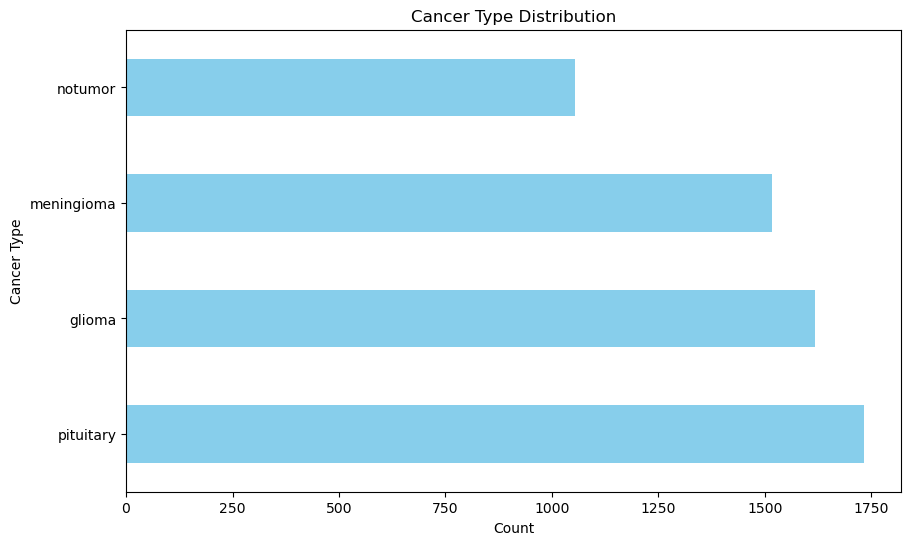


Sample images from the preprocessed dataset:


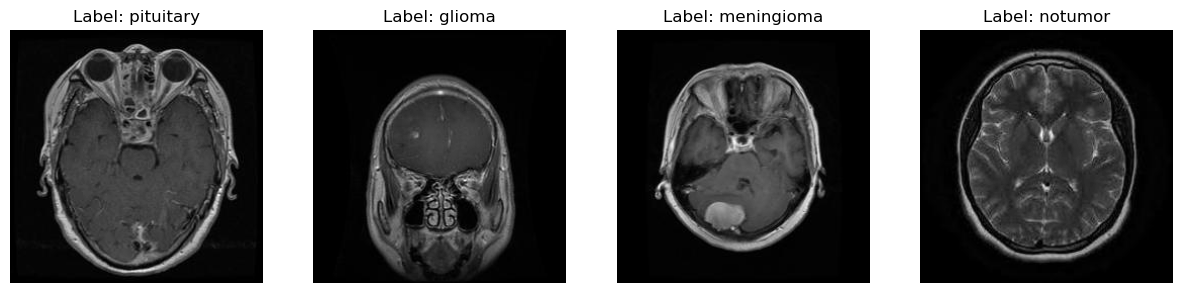

In [8]:
plt.figure(figsize = (10, 6))
label_distribution.plot(kind = "barh", title = "Cancer Type Distribution", color = "skyblue")
plt.xlabel("Count")  # Counts on the bottom (x-axis)
plt.ylabel("Cancer Type")  # Labels on the left (y-axis)
plt.show()

def display_sample_images(df, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize = (15, 5))
    for i, (idx, row) in enumerate(df.sample(num_samples).iterrows()):
        img = mpimg.imread(row["file_path"])
        axes[i].imshow(img, cmap = "gray")
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis("off")
    plt.show()

print("\nSample images from the preprocessed dataset:")
display_sample_images(df_5_9_cleaned)